# Visualisasi vektor medan magnet di Matahari

In [1]:
import json, urllib, numpy as np, matplotlib.pylab as plt, math
from astropy.io import fits
from sunpy.cm import color_tables as ct
import matplotlib.image as mpimg
import drms

In [2]:
def get_the_data():
    url = "http://jsoc.stanford.edu/cgi-bin/ajax/jsoc_info?ds=hmi.sharp_cea_720s_nrt[5596][2017.07.14_00:00:00_TAI]&op=rs_list&key=IMCRVAL1,NOAA_ARS,T_REC&seg=Bp,Br,Bt"
    response = urllib.urlopen(url)
    data = json.loads(response.read())
    print "Approximating",data['segments'][0]['name'],"as Bx."
    print "Approximating",data['segments'][1]['name'],"as Bz."
    print "Approximating",data['segments'][2]['name'],"as -By."
    bx = fits.open("http://jsoc.stanford.edu"+data['segments'][0]['values'][0])
    bz = fits.open("http://jsoc.stanford.edu"+data['segments'][1]['values'][0])
    by = fits.open("http://jsoc.stanford.edu"+data['segments'][2]['values'][0])
    by[1].data = -1.0*(np.array(by[1].data)) # flip the sign of by
    bx = bx[1].data
    by = by[1].data
    bz = bz[1].data
    IMCRVAL1 = float(data['keywords'][0]['values'][0])
    NOAA_ARS = str(data['keywords'][1]['values'][0])
    T_REC = str(data['keywords'][2]['values'][0])
    xsize = float(data['segments'][0]['dims'][0].rsplit('x', 1)[0])
    ysize = float(data['segments'][0]['dims'][0].rsplit('x', 1)[1])
    return bx, by, bz, IMCRVAL1, NOAA_ARS, T_REC, xsize, ysize

In [4]:
bx, by, bz, IMCRVAL1, NOAA_ARS, T_REC, xsize, ysize = get_the_data()

Approximating Bp as Bx.
Approximating Br as Bz.
Approximating Bt as -By.


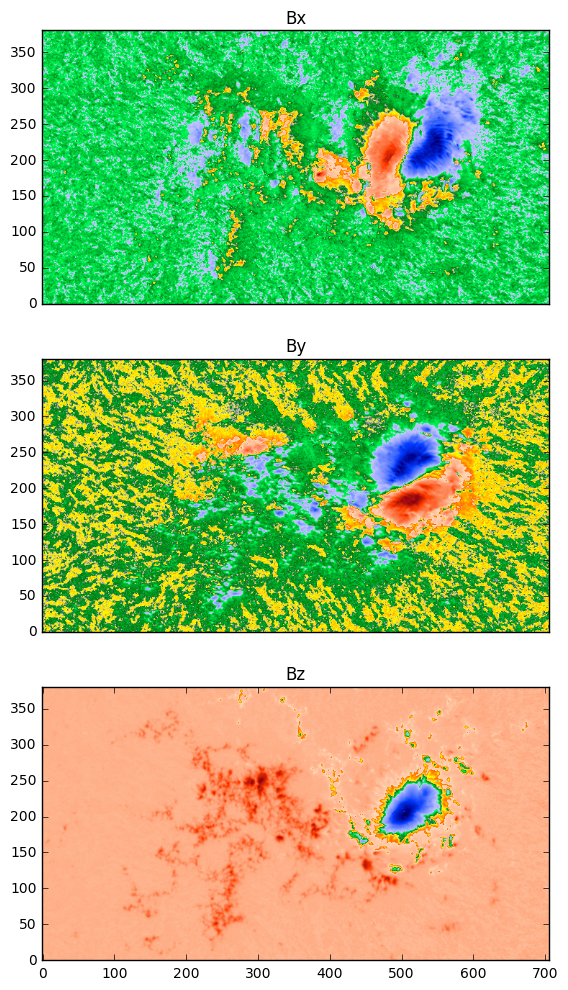

In [5]:
hmimag = plt.get_cmap('hmimag')
fig = plt.figure()
ax = fig.add_subplot(3,1,1)
ax.set_title('Bx')
ax.get_xaxis().set_ticks([])
plt.imshow(bx,cmap=hmimag,origin='lower')
ax = fig.add_subplot(3,1,2)
ax.set_title('By')
ax.get_xaxis().set_ticks([])
plt.imshow(by,cmap=hmimag,origin='lower')
ax = fig.add_subplot(3,1,3)
ax.set_title('Bz')
plt.imshow(bz,cmap=hmimag,origin='lower')
fig.set_size_inches(12,12)
fig.savefig('0000_sharp_cea_5596.png', dpi=200)
plt.show()


In [6]:
def create_the_rgbarray():
    nnx1 = 1920
    nny1 = 1080
    rgbarray = np.zeros([nny1, nnx1, 3], dtype='uint8')
    zbuff = np.zeros([nny1, nnx1], dtype=np.float)
    dsppm0 = 1.0 / float(nnx1)  # a dummy variable for length, 1.0 for full width of rgb image frame
    dsdat  = 1.0 / float(xsize) # a dummy variable for length, 1.0 for full width of input SHARP data 
    for j in range(nny1):
        for i in range(nnx1):
            rgbarray[nny1-1-j,i,0] = 100 + 40 * float(j) / float(nny1)
            rgbarray[nny1-1-j,i,1] = 100 + 40 * float(j) / float(nny1)
            rgbarray[nny1-1-j,i,2] =  50 + 20 * float(j) / float(nny1)
    return nnx1, nny1, rgbarray, zbuff, dsppm0, dsdat

In [7]:
nnx1, nny1, rgbarray, zbuff, dsppm0, dsdat = create_the_rgbarray()

The RGB array has the following dimensions:  (1080L, 1920L, 3L)


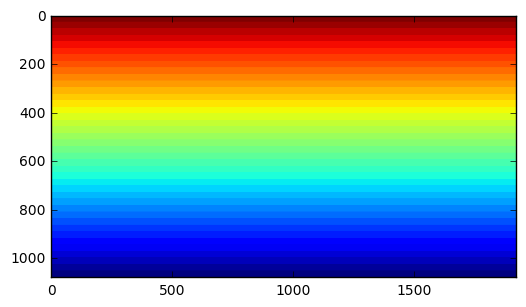

In [8]:
plt.imshow(rgbarray[:,:,0])
print "The RGB array has the following dimensions: ",rgbarray.shape
plt.show()

In [9]:
def define_a_viewpoint(dsppm0):
    zoomfact = 0.2     # zoom factor; mind that a smaller number means more zoom!
    th =  45.0         # viewing angle theta
    ph = 270.0 + 115.0 # viewing angle phi (set this equal to 270 for North to be up)
    dsppm = dsppm0 * zoomfact
    th = (th + 0.0001) / 180.0 * np.pi
    ph = ph / 180.0 * np.pi
    eyedist = 1.5
    eyex = math.sin(th) * math.cos(ph)
    eyey = math.sin(th) * math.sin(ph)
    eyez = math.cos(th)
    zx = 0.0
    zy = 0.0
    zz = 1.0
    prjxx = eyey * zz - eyez * zy
    prjxy = eyez * zx - eyex * zz
    prjxz = eyex * zy - eyey * zx
    a = np.sqrt(prjxx*prjxx + prjxy*prjxy + prjxz*prjxz)
    if (a < 0.00001):
        zx = 1.0
        zy = 0.0
        zz = 0.0
        prjxx = eyey * zz - eyez * zy
        prjxy = eyez * zx - eyex * zz
        prjxz = eyex * zy - eyey * zx
        a = np.sqrt(prjxx*prjxx + prjxy*prjxy + prjxz*prjxz)
    prjxx =-prjxx / a
    prjxy =-prjxy / a
    prjxz =-prjxz / a
    prjyx = prjxy * eyez - prjxz * eyey
    prjyy = prjxz * eyex - prjxx * eyez
    prjyz = prjxx * eyey - prjxy * eyex
    a = np.sqrt(prjyx*prjyx + prjyy*prjyy + prjyz*prjyz)
    prjyx = -prjyx / a
    prjyy = -prjyy / a
    prjyz = -prjyz / a
    lx =   eyex
    ly = - eyey
    lz =   np.sqrt(1.0 - (eyex*eyex + eyey*eyey))
    return prjxx, prjxy, prjxz, prjyx, prjyy, prjyz, lx, ly, lz, dsppm, eyex, eyey, eyez, eyedist, zoomfact

In [10]:
prjxx, prjxy, prjxz, prjyx, prjyy, prjyz, lx, ly, lz, dsppm, eyex, eyey, eyez, eyedist, zoomfact = define_a_viewpoint(dsppm0)

In [11]:
def draw_bz_at_surface(nnx1, nny1, zbuff, rgbarray, prjxx, prjxy, prjxz, prjyx, prjyy, prjyz, lx, ly, lz, dsppm, eyex, eyey, eyez, dsdat, eyedist):    
    for j in range(nny1):
        for i in range(nnx1):
            pixx = eyex + (float(i-nnx1/2) * prjxx + float(j-nny1/2) * prjyx) * dsppm
            pixy = eyey + (float(i-nnx1/2) * prjxy + float(j-nny1/2) * prjyy) * dsppm
            pixz = eyez + (float(i-nnx1/2) * prjxz + float(j-nny1/2) * prjyz) * dsppm
            losx = pixx - eyex * eyedist
            losy = pixy - eyey * eyedist
            losz = pixz - eyez * eyedist
            a = np.sqrt(losx*losx + losy*losy + losz*losz)
            losx =-losx / a
            losy =-losy / a
            losz =-losz / a
            a = pixz / losz
            zbuff[nny1-1-j,i] = a
            dsdatl = math.cos(IMCRVAL1 * np.pi / 180.0) * dsdat
            idat = int((pixx - a * losx) / dsdatl) + xsize/2
            jdat = int((pixy - a * losy) / dsdat)  + ysize/2
            if ((idat >= 0) and (jdat >= 0) and (idat < xsize) and (jdat < ysize)):
                bzplot = float(bz[jdat,idat])
                if (np.isfinite(bzplot) and (bzplot < 1e4) and (bzplot > -1e4)):
                    cc = abs(bzplot) / (np.sqrt(abs(bzplot)) + 20.0) / np.sqrt(1000.0)
                    if (cc > 0.999999):
                        cc = 0.999999
                    if (cc < 0.000001):
                        cc = 0.000001
                    cc = cc * 255.0
                    if (bzplot > 0.0):
                        ir = 255-cc
                        ig = 255-cc
                        ib = 255
                    else:
                        ir = 255
                        ig = 255 - cc
                        ib = 255 - cc
                else:
                    ir = 200
                    ig = 255
                    ib = 200
                if (ir < 0):
                    ir = 0
                if (ig < 0):
                    ig = 0
                if (ib < 0):
                    ib = 0
                if (ir > 255):
                    ir = 255
                if (ig > 255):
                    ig = 255
                if (ib > 255):
                    ib = 255
                rgbarray[nny1-1-j,i,0]=ir
                rgbarray[nny1-1-j,i,1]=ig
                rgbarray[nny1-1-j,i,2]=ib
    return rgbarray

In [12]:
rgbarray = draw_bz_at_surface(nnx1, nny1, zbuff, rgbarray, prjxx, prjxy, prjxz, prjyx, prjyy, prjyz, lx, ly, lz, dsppm, eyex, eyey, eyez, dsdat, eyedist)

c:\python27\lib\site-packages\ipykernel\__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


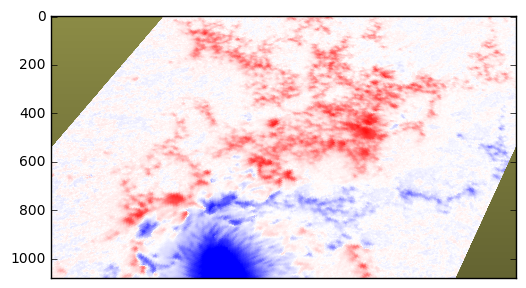

In [13]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.get_xaxis().set_ticks([])
plt.imshow(rgbarray)
plt.show()
fig.savefig('0000_bz_at_surface_sharp_cea_5596.png', dpi=200)

In [14]:
def draw_the_vector_hairs(rgbarray, zbuff, zoomfact):
    hairdense=int(2)
    n=0
    # for loop is for the data grid
    for j in range(0, int(ysize - 1), hairdense):
        for i in range(0, int(xsize - 1), hairdense):
            bxplot = float(bx[j,i])
            byplot = float(by[j,i])
            bzplot = float(bz[j,i])
            bbb = bxplot * bxplot + byplot * byplot + bzplot * bzplot
            if (np.isfinite(bbb) and (bbb < 1e8) and (bbb > -1e8)): # mind bbb is sqr of B
                bbb = np.sqrt(bbb + 1.0e-5)
                tx = bxplot / bbb # tx, ty, and tz define a normalized B vector
                ty = byplot / bbb
                tz = bzplot / bbb
                if (bzplot < 0.0):
                    tx = - tx
                    ty = - ty
                    tz = - tz
            bright1 = tx * eyex + ty * eyey + tz * eyez
            if (bright1 < 0.000001): 
                bright1 = 0.000001
            bright1 = bright1 * 0.3 + 0.7
            bright2 = tx * lx + ty * ly + tz * lz
            bright2 = np.sqrt(1.00001 - bright2 * bright2)
            bright2 = bright2 * 0.3 + 0.7
            bright0 = bright2 # final color index.
            if (bbb < 200.0):
                ccc = 0.0
            else:
                ccc = bbb / 400.0
                ccc = np.sqrt(ccc)
                if (ccc > 5.0):
                    ccc = 5.0
            stepfact  = 0.2 * zoomfact  # calculate how many segments are needed to draw one hair
            izendmany = 5.0 / stepfact  
            izend = int(ccc * izendmany)
            if (izend > 0):
                for iz in range(izend): # draw the vector hair 
                    aa = math.cos(IMCRVAL1 * 3.14 / 180.0)
                    x0 = float(i-xsize/2) * aa # x0, y0, and z0 define the footpoint position of a hedgehog hair
                    y0 = float(j-ysize/2)
                    z0 = 0.0
                    x1 = x0 + float(iz) * tx * stepfact # x1, y1, and z1 calculate the position of a segment of the hedgehog hair
                    y1 = y0 + float(iz) * ty * stepfact
                    z1 = z0 + float(iz) * tz * stepfact
                    x1 = x1 * dsdat
                    y1 = y1 * dsdat
                    z1 = z1 * dsdat
                    hcolor = 1.0 - float(iz) / float(izend) # gives a color gradation (each hedgehog color varies from yellow to brown as height)
                    if (hcolor < 0.5):
                        ir = int(127.0 * hcolor * 2.0)
                        ig = int(100.0 * hcolor * 2.0)
                        ib = 0
                    else:
                        ir = 155 + int(100.0 * (hcolor-0.5) * 2.0)
                        ig = 100 + int(155.0 * (hcolor-0.5) * 2.0)
                        ib =   0 + int( 50.0 * (hcolor-0.5) * 2.0)
                    ir = int(float(ir) * bright0)
                    ig = int(float(ig) * bright0)
                    ib = int(float(ib) * bright0)
                    if (ir < 0):
                        ir = 0
                    if (ig < 0):
                        ig = 0 
                    if (ib < 0):
                        ib = 0 
                    if (ir > 255):
                        ir = 255 
                    if (ig > 255):
                        ig = 255 
                    if (ib > 255):
                        ib = 255 
                    losx = x1 - eyex * eyedist # losx, losy, and losz calculates a line-of-sight vector from the segment of hair to the view point 
                    losy = y1 - eyey * eyedist #    together with the distance from the viewpoint to the segment.
                    losz = z1 - eyez * eyedist
                    a = np.sqrt(losx*losx + losy*losy + losz*losz)
                    losx = -losx / a
                    losy = -losy / a
                    losz = -losz / a
                    distance = (1.0 - (x1 * eyex + y1 * eyey + z1 * eyez))/(losx * eyex + losy * eyey + losz * eyez)
                    x2 = x1 + distance * losx  # x2, y2, z3, xp, yp, and ixp, and iyp calculate the integer address of ppmarray (or projection plane)
                    y2 = y1 + distance * losy
                    z2 = z1 + distance * losz
                    xp = (x2 - eyex) * prjxx + (y2 - eyey) * prjxy + (z2 - eyez) * prjxz
                    yp = (x2 - eyex) * prjyx + (y2 - eyey) * prjyy + (z2 - eyez) * prjyz
                    ixp = int(xp/dsppm) + nnx1/2
                    iyp = int(yp/dsppm) + nny1/2
                    # the distance is used to judge if the segment is the nearest one to eye: 
                    # If something is already in between the eyes, we do not need to use values of an object behind other object(s).
                    if ((ixp < nnx1) and (iyp < nny1) and (ixp > 0) and (iyp > 0)):
                        if (distance < zbuff[nny1-1-iyp,ixp]):
                            zbuff[nny1-1-iyp,ixp] = a
                            rgbarray[nny1-1-iyp,ixp,0] = ir
                            rgbarray[nny1-1-iyp,ixp,1] = ig
                            rgbarray[nny1-1-iyp,ixp,2] = ib
    return rgbarray

In [15]:
rgbarray = draw_the_vector_hairs(rgbarray, zbuff, zoomfact)

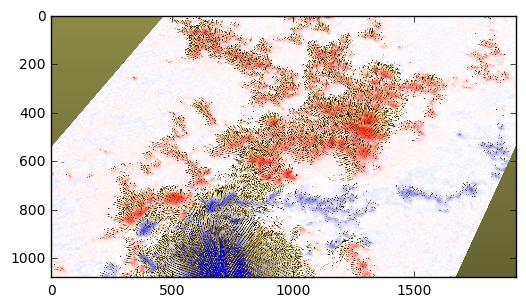

In [16]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.imshow(rgbarray)
plt.show()

In [17]:
# compass and clock
def draw_a_compass_and_clock(rgbarray, dsppm, eyex, eyey, eyez, prjxx, prjxy, prjxz, prjyx, prjyy, prjyz, eyedist):
    n=0
    csize = nny1 / 5
    i = 25 + csize / 2 - 1
    j = 25 + csize / 2 - 1
    pixx = eyex + (float(i-nnx1/2) * prjxx + float(j-nny1/2) * prjyx) * dsppm
    pixy = eyey + (float(i-nnx1/2) * prjxy + float(j-nny1/2) * prjyy) * dsppm
    pixz = eyez + (float(i-nnx1/2) * prjxz + float(j-nny1/2) * prjyz) * dsppm
    losx = pixx - eyex * eyedist
    losy = pixy - eyey * eyedist
    losz = pixz - eyez * eyedist
    a = np.sqrt(losx*losx + losy*losy + losz*losz)
    losx =-losx / a
    losy =-losy / a
    losz =-losz / a
    a = (pixz - 0.2) / losz # compass is at z=0.2
    cmpx0 = pixx - a * losx
    cmpy0 = pixy - a * losy
    i = 25 + csize     - 1
    j = 25 + csize / 2 - 1
    pixx = eyex + (float(i-nnx1/2) * prjxx + float(j-nny1/2) * prjyx) * dsppm
    pixy = eyey + (float(i-nnx1/2) * prjxy + float(j-nny1/2) * prjyy) * dsppm
    pixz = eyez + (float(i-nnx1/2) * prjxz + float(j-nny1/2) * prjyz) * dsppm
    losx = pixx - eyex * eyedist
    losy = pixy - eyey * eyedist
    losz = pixz - eyez * eyedist
    a = np.sqrt(losx*losx + losy*losy + losz*losz)
    losx =-losx / a
    losy =-losy / a
    losz =-losz / a
    a = (pixz - 0.2) / losz # compass is at z=0.2
    cmpx1 = pixx - a * losx
    cmpy1 = pixy - a * losy
    cmprad = np.sqrt((cmpx1 - cmpx0)*(cmpx1 - cmpx0) + (cmpy1 - cmpy0)*(cmpy1 - cmpy0) + 1e-5)
    for j in range(25, 25 + csize - 1):
        for i in range(25, 25 + csize - 1):
            pixx = eyex + (float(i-nnx1/2) * prjxx + float(j-nny1/2) * prjyx) * dsppm
            pixy = eyey + (float(i-nnx1/2) * prjxy + float(j-nny1/2) * prjyy) * dsppm
            pixz = eyez + (float(i-nnx1/2) * prjxz + float(j-nny1/2) * prjyz) * dsppm
            losx = pixx - eyex * eyedist
            losy = pixy - eyey * eyedist
            losz = pixz - eyez * eyedist
            a = np.sqrt(losx*losx + losy*losy + losz*losz)
            losx =-losx / a
            losy =-losy / a
            losz =-losz / a
            a = (pixz - 0.2) / losz # compass is at z=0.2
            cmpx = pixx - a * losx
            cmpy = pixy - a * losy
            a = np.sqrt((cmpx - cmpx0)*(cmpx - cmpx0) + (cmpy - cmpy0)*(cmpy - cmpy0) + 1e-5)
            if (a < cmprad * 0.9):
                ir = rgbarray[nny1-1-j,i,0]
                ig = rgbarray[nny1-1-j,i,1]
                ib = rgbarray[nny1-1-j,i,2]
                if ((a < cmprad * 0.9) and (a > cmprad * 0.8)):
                    ir =(ir + 2 * 1)/3 # compass frame will be transparent dark brown.
                    ig =(ig + 2 * 1)/3
                    ib =(ib + 2 * 0)/3
                else:
                    cx = (cmpx - cmpx0) / cmprad
                    cy = (cmpy - cmpy0) / cmprad
                    if ((cy > 0.0) and (cy + 9.0 * cx < 0.8) and (cy - 9.0 * cx < 0.8)):
                        ir =(ir + 2 * 255)/3 # north
                        ig =(ig + 2 * 0)/3
                        ib =(ib + 2 * 0)/3
                    if ((cy < 0.0) and (cy + 9.0 * cx > -0.8) and (cy - 9.0 * cx > -0.8)):
                        ir =(ir + 2 * 0)/3 # south
                        ig =(ig + 2 * 0)/3
                        ib =(ib + 2 * 255)/3
                if (ir < 0):
                    ir = 0
                if (ig < 0):
                    ig = 0 
                if (ib < 0):
                    ib = 0 
                if (ir > 255):
                    ir = 255 
                if (ig > 255):
                    ig = 255 
                if (ib > 255):
                    ib = 255
                rgbarray[nny1-1-j,i,0]=ir
                rgbarray[nny1-1-j,i,1]=ig
                rgbarray[nny1-1-j,i,2]=ib
            iw = i -(25 + csize / 2 - 1)
            jw = j -(25 + csize / 2 - 1)
            fiw = float(iw)
            fjw = float(jw)
            fwork = fiw*fiw + fjw*fjw
            a = np.sqrt(fwork) / float(csize/2)
            if ((a > 0.9) and (a < 1.0)):
                ir = rgbarray[nny1-1-j,i,0]
                ig = rgbarray[nny1-1-j,i,1]
                ib = rgbarray[nny1-1-j,i,2]
                fi = float(iw)
                fj = float(jw)
                if (iw == 0):
                    if (fj > 0):
                        th = 90.0
                    else:
                        th = -90.0
                else:
                    if (iw < 0):
                        th = np.arctan(fj/fi)
                    else:
                        th = np.arctan(fj/fi) + np.pi
                th = th / np.pi * 180.0
                th = 90.0 - th + 3600.0
                th = th / (360.0/24.0)
                th = np.fmod(th,1.0)
                th = 1.0 - th
                irf = int(th * 50.0 + 25.0) # dark brown
                igf = int(th * 50.0 + 25.0)
                ibf = int(th * 00.0 + 00.0)
                fwork = 0.0 + 0.2 * float(n) # ... float hour, given the data start 2:00UT. a trick allowing being lazy.
                fwork = fwork / 24.0 * np.pi * 2.0
                fi = csize/2.0 * 0.95 * np.sin(fwork) - float(iw)
                fj = csize/2.0 * 0.95 * np.cos(fwork) - float(jw)
                fwork = np.sqrt(fi*fi + fj*fj)/(0.05 * csize * 0.5)
                if (fwork < 1.0):
                    fwork = 1.0 / (1.0 + fwork * fwork)
                    irf = irf + fwork * 100.0
                    igf = igf + fwork * 255.0 # bright cyan
                    ibf = ibf + fwork * 255.0
                ir = int(irf)
                ig = int(igf)
                ib = int(ibf)
                if (ir < 0):
                    ir = 0
                if (ig < 0):
                    ig = 0 
                if (ib < 0):
                    ib = 0 
                if (ir > 255):
                    ir = 255 
                if (ig > 255):
                    ig = 255 
                if (ib > 255):
                    ib = 255 
                rgbarray[nny1-1-j,i,0]=ir
                rgbarray[nny1-1-j,i,1]=ig
                rgbarray[nny1-1-j,i,2]=ib
    return rgbarray

In [18]:
rgbarray = draw_a_compass_and_clock(rgbarray, dsppm, eyex, eyey, eyez, prjxx, prjxy, prjxz, prjyx, prjyy, prjyz, eyedist)

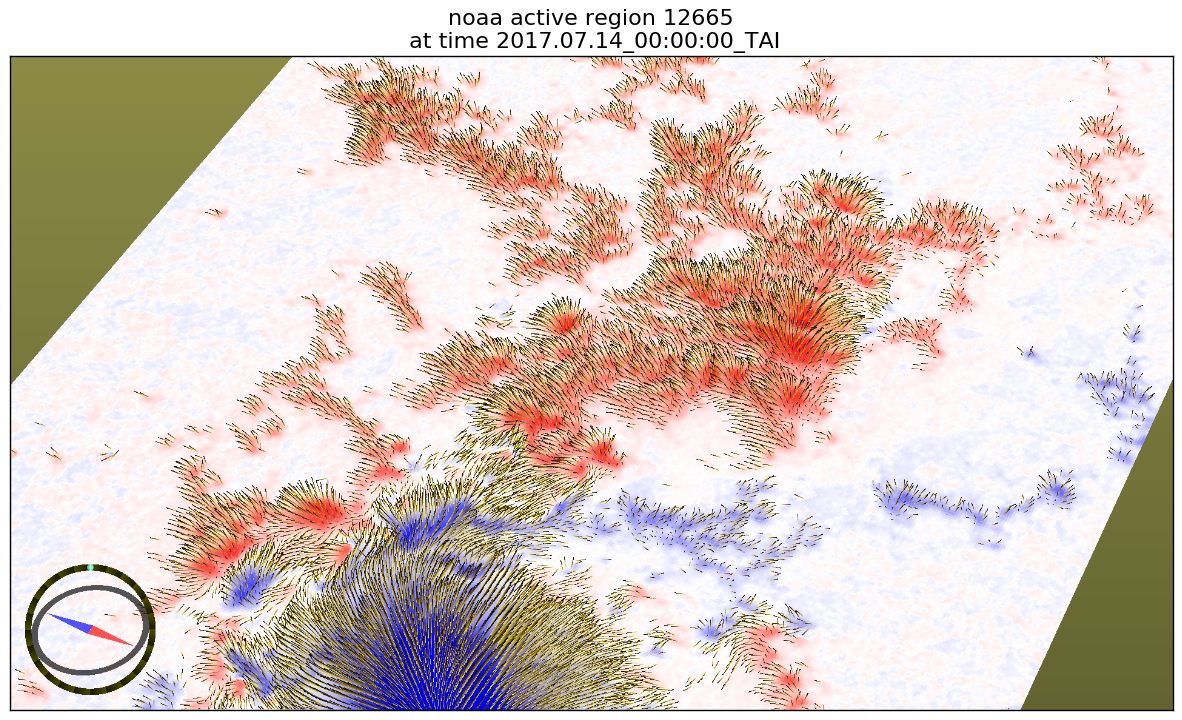

In [19]:
fig = plt.figure()
text_style = {'color'  : 'black','weight' : 'normal','size'   : 16}
ax = fig.add_subplot(1,1,1)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
ax.set_title('noaa active region '+NOAA_ARS+'\n at time '+T_REC, fontdict = text_style)
plt.imshow(rgbarray)
#fig.savefig('hedgehog.png',dpi=500)
fig.savefig('0000_Vector_sharp_cea_5596.png', dpi=500)
fig.set_size_inches(15,15)
plt.show()